In [71]:
import copy
import random

import gym
import numpy as np
import torch
import torch.nn as nn
import tqdm
from commons.buffers import replay_memory
from matplotlib import pyplot as plt

torch.set_printoptions(precision=7, sci_mode=False)

In [76]:
no_of_frames = 100000
_e1, _e2, _ed = 1.0, 0.01, 2000
eps = lambda x: _e2 + (_e1 - _e2) * np.exp(-x / _ed)
batch_size = 4
gamma = 0.99
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Vmin, Vmax = -10, 10
num_atoms = 51

env_id = "CartPole-v1"
env = gym.make(env_id)

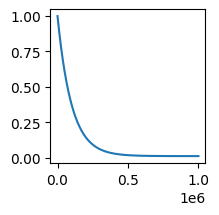

In [77]:
plt.figure(figsize=(2, 2))
plt.plot([eps(i) for i in range(1, no_of_frames + 1)])

In [ ]:
class CategoricalDQN(nn.Module):
    def __init__(self, input_shape, action_space):
        super(CategoricalDQN, self).__init__()
        self.action_space = action_space
        self.l = nn.Sequential(
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_space * num_atoms),
        )

    def forward(self, x):
        x = self.l(x)
        x = x.reshape(x.shape[0], self.action_space, num_atoms)
        x = nn.functional.softmax(x, dim=-1)
        return x

    def act(self, x, eps):
        with torch.no_grad():
            if random.random() < eps:
                return np.random.randint(self.action_space)
            else:
                x = torch.tensor(x).float().unsqueeze(0).to(device)
                dist = self.forward(x).detach()
                dist = dist.mul(torch.linspace(Vmin, Vmax, num_atoms).to(device))
                action = dist.sum(2).max(1)[1][0].item()
                return action

In [ ]:
net = CategoricalDQN(env.observation_space.shape[0], env.action_space.n).to(device)
target = copy.deepcopy(net).to(device)
buffer = replay_memory(10000)
optimizer = torch.optim.Adam(net.parameters())

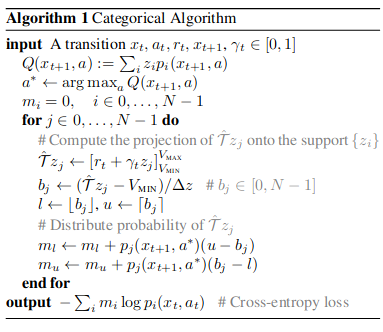


```python
m = torch.zeros(batch_size, num_atoms).to(device)
for i in range(m.shape[0]):
     for j in range(m.shape[1]):
        m[i, l[i,j]] += probl[i,j]
        m[i, u[i,j]] += probu[i,j]
```

why not this?

```python
m[i, l] += next_dist * (u.float() - bj)
m[i, u] += next_dist * (bj - l.float())
```

this wont work because some duplicate index present in it
for example say 25 appears twice, then the commented code only takes
sum once which is wrong

proof:

```python
m = torch.zeros(10)
l = torch.arange(0, 10, 1)
l[4]=l[3]
print('index:',l)
m[l] += torch.ones(10)
print(m)
```

`>>> index: tensor([0, 1, 2, 3, 3, 5, 6, 7, 8, 9])`<br>
`tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])`

we expect m[3] to be 2 since 3 appears twice.


In [ ]:
def projection_distribution(next_state, rewards, dones):
    batch_size = next_state.size(0)
    delta_z = (Vmax - Vmin) / (num_atoms - 1)
    support = torch.linspace(Vmin, Vmax, num_atoms).to(device)
    next_dist = target(next_state) * support
    next_act = next_dist.sum(2).max(1)[1]
    next_dist = next_dist[torch.arange(next_dist.size(0)), next_act.data]

    rewards = rewards.view(-1, 1).expand([batch_size, num_atoms])
    dones = dones.view(-1, 1).expand([batch_size, num_atoms])

    Tz = rewards + gamma * (1 - dones) * support
    Tz = Tz.clamp(min=Vmin, max=Vmax)
    bj = (Tz - Vmin) / delta_z
    l = torch.floor(bj).long()
    u = torch.ceil(bj).long()

    probl = next_dist * (u - bj)
    probu = next_dist * (bj - l)


    m = torch.zeros(batch_size, num_atoms).to(device)
    m.scatter_add_(1, l, probl)
    m.scatter_add_(1, u, probu)
    return m

In [ ]:
def gradient_descent_c51_dqn():
    batches = buffer.replay(size=batch_size)
    states, actions, rewards, next_states, done = zip(*batches)
    states = torch.tensor(states, dtype=torch.float32).to(device)
    with torch.no_grad():
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    actions = torch.LongTensor(actions).to(device)
    done = torch.FloatTensor(done).to(device)

    # projection distribution
    pro_dist = projection_distribution(next_states, rewards, done)

    dist =  net(states)
    dist = dist[torch.arange(len(actions)), actions]
    
    loss = (-(pro_dist * dist.clamp(min=1e-5, max=1 - 1e-5).log()).sum(-1)).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
rew = 0
rewards = []
state, _ = env.reset()
for i in tqdm.tqdm(range(1, 1 + no_of_frames)):
    action = net.act(state, eps(i))
    new_state, reward, done, _, _ = env.step(action)
    buffer.store(state, action, reward, new_state, float(done))
    rew += reward
    state = new_state
    if len(buffer) > 100:
        gradient_descent_c51_dqn()
    if i % 200==0:
        target = copy.deepcopy(net)
    if done:
        rewards.append(rew)
        state, _ = env.reset()
        mean_reward = sum(rewards) / len(rewards)
        rew = 0

plt.plot(rewards)
plt.show()
print(f"Maximum Reward: {max(rewards)}")